# <font face="Arial" color="green">General description</font>

<h1 class="dataset-header-v2__title">Synthetic Financial Datasets For Fraud Detection</h1>

<div class="markdown-converter__text--rendered"><h1>Context</h1>
<p>There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.</p>
<p>We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.</p>
<h1>Content</h1>
<p>PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is  the provider of the mobile financial service which is currently running in more than 14 countries all around the world.</p>
<p>This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.</p>
<h1>Headers</h1>
<p>This is a sample of 1 row with headers explanation:</p>
<p>1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0</p>
<p>step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).</p>
<p>type - CASH-IN, CASH-OUT, DEBIT, PAYMENT  and TRANSFER.</p>
<p>amount -<br>
 amount of the transaction in local currency.</p>
<p>nameOrig - customer who started the transaction</p>
<p>oldbalanceOrg - initial balance before the transaction</p>
<p>newbalanceOrig - new balance after the transaction</p>
<p>nameDest - customer who is the recipient of the transaction</p>
<p>oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).</p>
<p>newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).</p>
<p>isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.</p>
<p>isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.</p>
<h1>Past Research</h1>
<p>There are 5 similar files that contain the run of 5 different scenarios. These files are better explained at my PhD thesis chapter 7 (PhD Thesis Available here <a rel="noreferrer nofollow" href="http://urn.kb.se/resolve?urn=urn:nbn:se:bth-12932)">http://urn.kb.se/resolve?urn=urn:nbn:se:bth-12932)</a>.</p>
<p>We ran PaySim several times using random seeds for 744 steps, representing each hour of one month of real time, which matches the original logs. Each run took around 45 minutes on an i7 intel processor with 16GB of RAM. The final result of a run contains approximately 24 million of financial records divided into the 5 types of categories: CASH-IN, CASH-OUT, DEBIT, PAYMENT  and TRANSFER.</p>
<h1>Acknowledgements</h1>
<p>This work is part of the research project ”Scalable resource-efficient systems for big data analytics” funded<br>
by the Knowledge Foundation (grant: 20140032) in Sweden.</p>
<p>Please refer to this dataset using the following citations: </p>
<p>PaySim first paper of the simulator:</p>
<p>E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016</p></div>


https://www.kaggle.com/ealaxi/paysim1

# <font face="Arial" color="green">Library Imports</font>

In [1]:
import time
import warnings
import random
import pickle
import time
import pandas                    as pd
import numpy                     as np
import matplotlib.pyplot         as plt
import seaborn                   as sns
import scipy.stats               as stats
import xgboost                   as xgb

from math                        import ceil
from math                        import floor
from sklearn.model_selection     import train_test_split
from sklearn.model_selection     import StratifiedKFold
from sklearn.model_selection     import cross_val_score
from sklearn.model_selection     import StratifiedKFold
from sklearn.model_selection     import RandomizedSearchCV
from sklearn.preprocessing       import RobustScaler, LabelEncoder
from sklearn.ensemble            import RandomForestClassifier
from sklearn.linear_model        import LogisticRegression
from sklearn.neighbors           import KNeighborsClassifier
from sklearn                     import metrics
from boruta                      import BorutaPy

from pycorrcat.pycorrcat         import plot_corr, corr_matrix

warnings.filterwarnings("ignore")

# <font face="Arial" color="green">Helper functions</font>

In [2]:
def jupyter_settings():
    
    pd.options.display.max_columns = None   
    


warnings.filterwarnings("ignore")
jupyter_settings()



def get_model_metrics(model_name, model, X_train, y_train, X_test, y_test):
    
    

    inst_model = model.fit(X_train, y_train)


    y_pred = inst_model.predict(X_test)


    # Metrics:



    # Accuracy

    print('Accuracy: {}\n'.format(round(metrics.accuracy_score(y_test, y_pred),3)))


    # Balanced Accuracy

    print('Balanced Accuracy: {}\n'.format(round(metrics.balanced_accuracy_score(y_test, y_pred),3)))


    # AUC ROC


    # fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1) <- sintax

    fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                             np.array([i[1] for i in inst_model.predict_proba(X_test)]), 
                                             pos_label=1)

    metrics.auc(fpr, tpr)

    print('AUC-ROC: {}\n'.format(round(metrics.auc(fpr, tpr),3)))


    # Classification report

    print('Classification report:\n\n {}\n'.format(metrics.classification_report(y_test, y_pred)))


    # Gathering metrics for this estimator

    inst_model_accuracy = metrics.accuracy_score(y_test, y_pred)

    inst_model_bal_accuracy = metrics.balanced_accuracy_score(y_test, y_pred)

    inst_model_auc = metrics.auc(fpr, tpr)

    inst_model_precision = metrics.precision_score(y_test, y_pred)

    inst_model_f1 = metrics.f1_score(y_test, y_pred)

    inst_model_recall = metrics.recall_score(y_test, y_pred)
    
    
    
    # Getting df
    
    
    df = pd.DataFrame(data=[model_name, inst_model_accuracy,
                            inst_model_bal_accuracy, 
                            inst_model_auc, 
                            inst_model_precision, 
                            inst_model_f1, 
                            inst_model_recall]).transpose()

    df.columns = ['Model name', 'Accuracy', 'Balanced Accuracy', 'AUC', 'Precision', 'F1-score', 'Recall']
    
    return df    

# 1 - Data import and basic inspection 

## 1.1 data loading and checking

In [44]:
# Data load

df = pd.read_csv('/mnt/d/Gustavo/fraud-detection/PS_20174392719_1491204439457_log.csv')

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [45]:
# Data dimensions

print('\nData dimensions:\n')
print('Number of rows: {}'.format(df.shape[0]))
print('Number of columns: {}'.format(df.shape[1]))


Data dimensions:

Number of rows: 6362620
Number of columns: 11


In [46]:
# Checking data types

df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [47]:
# Checking data info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [48]:
# Checking for NA's

df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [49]:
# Checking for duplicate rows

df.duplicated().sum()

0

In [50]:
df[df.duplicated()]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [51]:
# Response variable

df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [52]:
# Response variable - Percentage

print('Percentage of Non-Fraud transactions: {}'.format(df['isFraud'].value_counts()[0]/df.shape[0]))
print('Percentage of Non-Fraud transactions: {}'.format(df['isFraud'].value_counts()[1]/df.shape[0]))

Percentage of Non-Fraud transactions: 0.9987091795518198
Percentage of Non-Fraud transactions: 0.001290820448180152


## 1.2 descriptive statistics

### 1.2.1 descriptive statistics

In [53]:
# Numerical and categorical attributes

num_attrib = df.select_dtypes(include=['int64', 'float64']) # numerical attributes

cat_attrib = df.select_dtypes(exclude=['int64', 'float64']) # categorical attributes

In [54]:
# Descriptive statistics

pd.DataFrame(data=[num_attrib.apply(np.min),
          num_attrib.apply(np.max),
          num_attrib.apply(lambda x: np.max(x) - np.min(x)),
          num_attrib.apply(np.mean),
          num_attrib.apply(np.median),
          num_attrib.apply(np.std),
          num_attrib.apply(lambda x: x.skew()),
          num_attrib.apply(lambda x: x.kurtosis())],
             
             index=np.array(['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])).transpose()

,min,max,range,mean,median,std,skew,kurtosis
step,1.0,7.430000e+02,7.420000e+02,2.433972e+02,239.000,1.423320e+02,0.375177,0.329071
amount,0.0,9.244552e+07,9.244552e+07,1.798619e+05,74871.940,6.038582e+05,30.993949,1797.956705
oldbalanceOrg,0.0,5.958504e+07,5.958504e+07,8.338831e+05,14208.000,2.888242e+06,5.249136,32.964879
newbalanceOrig,0.0,4.958504e+07,4.958504e+07,8.551137e+05,0.000,2.924048e+06,5.176884,32.066985
oldbalanceDest,0.0,3.560159e+08,3.560159e+08,1.100702e+06,132705.665,3.399180e+06,19.921758,948.674125
newbalanceDest,0.0,3.561793e+08,3.561793e+08,1.224996e+06,214661.440,3.674129e+06,19.352302,862.156508
isFraud,0.0,1.000000e+00,1.000000e+00,1.290820e-03,0.000,3.590479e-02,27.779538,769.702982
isFlaggedFraud,0.0,1.000000e+00,1.000000e+00,2.514687e-06,0.000,1.585775e-03,630.603629,397659.062500


### 1.2.2 general view of attributes

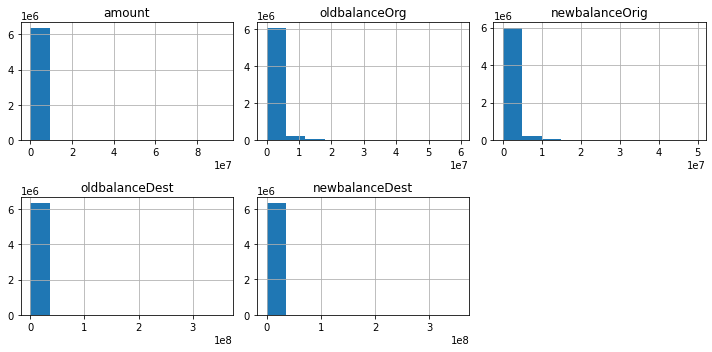

In [55]:
# Numerical attribute view

# Exploring continuous attributes

num_attrib.select_dtypes('float64').hist(figsize=(10,5),layout=(2,3))
plt.tight_layout();

In [56]:
# Exploring 'amount' - Counts and bins

counts, bins = np.histogram(num_attrib.loc[num_attrib['amount']>0, 'amount'], 
                               bins=20, 
                               range=(num_attrib.loc[num_attrib['amount']>0, 'amount'].min(),
                                      num_attrib.loc[num_attrib['amount']>0, 'amount'].max()))

In [57]:
counts

array([6350041,    6419,    4533,     657,     326,     207,     143,
           113,      64,      23,      34,      18,      11,       8,
             2,       4,       0,       0,       0,       1])

In [58]:
bins

array([1.00000000e-02, 4.62227584e+06, 9.24455167e+06, 1.38668275e+07,
       1.84891033e+07, 2.31113792e+07, 2.77336550e+07, 3.23559308e+07,
       3.69782067e+07, 4.16004825e+07, 4.62227583e+07, 5.08450342e+07,
       5.54673100e+07, 6.00895858e+07, 6.47118617e+07, 6.93341375e+07,
       7.39564133e+07, 7.85786891e+07, 8.32009650e+07, 8.78232408e+07,
       9.24455166e+07])

<AxesSubplot:>

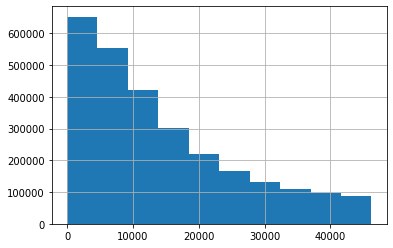

In [59]:
# Most of transactions involves amount lower than 40000

num_attrib.loc[num_attrib['amount']<4.62227584e+04, 'amount'].hist()

<AxesSubplot:xlabel='amount'>

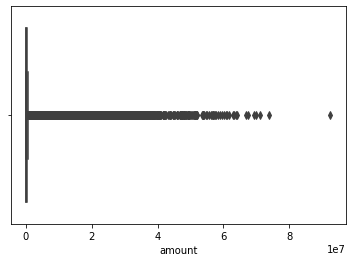

In [60]:
# However there are lots of outliers - higher amount transactions 

sns.boxplot(num_attrib.loc[num_attrib['amount']>0, 'amount'], orient='h')

<AxesSubplot:>

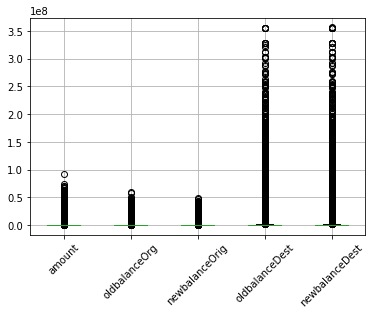

In [61]:
# Boxplot of continuous variables - lots of outliers

df.select_dtypes('float64').boxplot(rot=45)

<AxesSubplot:>

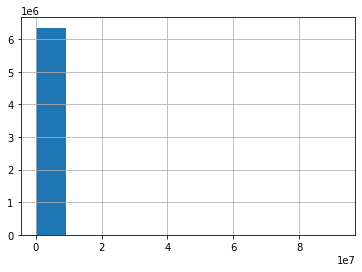

In [62]:
# The frequencies of transactions of higher amounts are extremy low 
## and are supressed by most frequent transactions

num_attrib.loc[:, 'amount'].hist()

<AxesSubplot:xlabel='isFraud', ylabel='amount'>

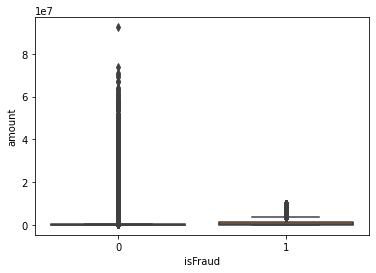

In [63]:
# Boxplot - 'amount'

sns.boxplot(x='isFraud', y='amount', data=num_attrib)

<AxesSubplot:xlabel='isFraud', ylabel='amount'>

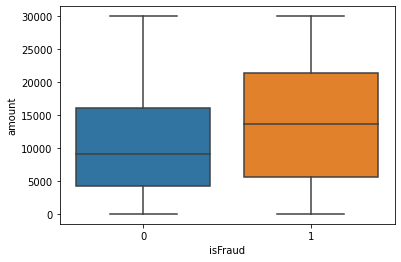

In [64]:
# Boxplot - 'amount' (expanded)

sns.boxplot(x='isFraud', y='amount', data=num_attrib[num_attrib['amount']<3.0e+04])



In [65]:
# Categorical attributes check

cat_attrib

,type,nameOrig,nameDest
0,PAYMENT,C1231006815,M1979787155
1,PAYMENT,C1666544295,M2044282225
2,TRANSFER,C1305486145,C553264065
3,CASH_OUT,C840083671,C38997010
4,PAYMENT,C2048537720,M1230701703
...,...,...,...
6362615,CASH_OUT,C786484425,C776919290
6362616,TRANSFER,C1529008245,C1881841831
6362617,CASH_OUT,C1162922333,C1365125890
6362618,TRANSFER,C1685995037,C2080388513


In [66]:
# Categorical attributes view

# Unbalanced data makes direct comparisons dificult - we normalized the data here

cat_view = pd.DataFrame(df[['isFraud','type']].groupby(['isFraud','type']).size().reset_index())

cat_view.columns = ['isFraud','type', 'count']

#column 'norm_count' - normalizing by the total count of each category in the column 'isFraud'
cat_view.loc[cat_view['isFraud']==1,'norm_count'] = cat_view['count'] / cat_view.loc[cat_view['isFraud']==1, 'count'].sum()

cat_view.loc[cat_view['isFraud']==0,'norm_count'] = cat_view['count'] / cat_view.loc[cat_view['isFraud']==0, 'count'].sum()

cat_view

,isFraud,type,count,norm_count
0,0,CASH_IN,1399284,0.220207
1,0,CASH_OUT,2233384,0.351470
2,0,DEBIT,41432,0.006520
3,0,PAYMENT,2151495,0.338583
4,0,TRANSFER,528812,0.083220
5,1,CASH_OUT,4116,0.501157
6,1,TRANSFER,4097,0.498843


<AxesSubplot:xlabel='type', ylabel='norm_count'>

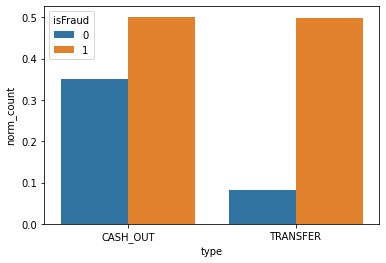

In [67]:
# There is no CASH_IN, DEBIT, PAYMENT in fraud transactions - 'type' variable might be important

# Let's compare CASH_OUT and TRANSFER

# When there is fraud percentage of CASH_OUT and TRANSFER transactions are higher compared to when there is not

sns.barplot(x='type', 
            y='norm_count', 
            hue='isFraud', 
            data=cat_view[(cat_view['type']=='CASH_OUT') | (cat_view['type']=='TRANSFER')])

# 2 - Feature engineering

In [68]:
df1 = df.copy()

## 2.1 creating new features

From 'step' column it is possible to create new time-related features that might help data exploration and learning process

In [69]:
# Day of month

df1['day_of_month'] = df1['step'].apply(lambda x: ceil(x/24))

df1['day_of_month']

0           1
1           1
2           1
3           1
4           1
           ..
6362615    31
6362616    31
6362617    31
6362618    31
6362619    31
Name: day_of_month, Length: 6362620, dtype: int64

In [70]:
# Week of month

df1['week_of_month'] = df1['step'].apply(lambda x: ceil(x/168))

df1['week_of_month']

0          1
1          1
2          1
3          1
4          1
          ..
6362615    5
6362616    5
6362617    5
6362618    5
6362619    5
Name: week_of_month, Length: 6362620, dtype: int64

In [71]:
# Creating aux column 'min_step_of_day'

for i in df1['day_of_month'].unique():
    
    df1.loc[df1['day_of_month']==i,'min_step_of_day'] = df1.loc[df1['day_of_month']==i, 'step'].min()


# Creating 'hour_of_day' column

df1['hour_of_day'] = df1['step'] - df1['min_step_of_day']

df1['hour_of_day']

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
           ... 
6362615    22.0
6362616    22.0
6362617    22.0
6362618    22.0
6362619    22.0
Name: hour_of_day, Length: 6362620, dtype: float64

In [72]:
# Creating aux column 'min_day_of_week'


for i in df1['week_of_month'].unique():
    
    df1.loc[df1['week_of_month']==i, 'min_day_of_week'] = df1.loc[df1['week_of_month']==i, 'day_of_month'].min()



# Creating 'day_of_week' column


df1['day_of_week'] = ((df1['day_of_month'] - df1['min_day_of_week'])+1)

df1['day_of_week']    

0          1.0
1          1.0
2          1.0
3          1.0
4          1.0
          ... 
6362615    3.0
6362616    3.0
6362617    3.0
6362618    3.0
6362619    3.0
Name: day_of_week, Length: 6362620, dtype: float64

In [73]:
# Creating 'is_weekend' column

df1['is_weekend'] = df1['day_of_week'].apply(lambda x: 'weekend' if x == 1 or x == 7 else 'weekdays')

df1['is_weekend']

0           weekend
1           weekend
2           weekend
3           weekend
4           weekend
             ...   
6362615    weekdays
6362616    weekdays
6362617    weekdays
6362618    weekdays
6362619    weekdays
Name: is_weekend, Length: 6362620, dtype: object

In [74]:
# Creating 'time_of_day' column

df1['time_of_day'] = df1['hour_of_day'].apply(lambda x: 'AM' if x <= 12 else 'PM')

df1['time_of_day']

0          AM
1          AM
2          AM
3          AM
4          AM
           ..
6362615    PM
6362616    PM
6362617    PM
6362618    PM
6362619    PM
Name: time_of_day, Length: 6362620, dtype: object

In [75]:
# Creating 'period_of_day' column

df1['period_of_day'] = ['Morning' if i<=12 else 'Afternoon' if i>12 and i<=18 else 'Evening' for i in df1['hour_of_day']]

df1['period_of_day']

0          Morning
1          Morning
2          Morning
3          Morning
4          Morning
            ...   
6362615    Evening
6362616    Evening
6362617    Evening
6362618    Evening
6362619    Evening
Name: period_of_day, Length: 6362620, dtype: object

Columns 'nameOrig' and 'nameDest' carry information that allow us to categorize both transaction origin and transaction destiny (Costumer if the name starts with C and Merchant if the name starts with M) 

In [76]:
# Creating 'orig_type' column

df1['orig_type'] = ['Merchant' if i[0]== 'M' else 'Costumer' for i in df1['nameOrig']]

df1['orig_type']

0          Costumer
1          Costumer
2          Costumer
3          Costumer
4          Costumer
             ...   
6362615    Costumer
6362616    Costumer
6362617    Costumer
6362618    Costumer
6362619    Costumer
Name: orig_type, Length: 6362620, dtype: object

In [77]:
# Creating 'dest_type' column

df1['dest_type'] = ['Merchant' if i[0]== 'M' else 'Costumer' for i in df1['nameDest']]

df1['dest_type']

0          Merchant
1          Merchant
2          Costumer
3          Costumer
4          Merchant
             ...   
6362615    Costumer
6362616    Costumer
6362617    Costumer
6362618    Costumer
6362619    Costumer
Name: dest_type, Length: 6362620, dtype: object

From  old/new balance Origin/Dest it is possible to create new category informing if it is zero or non-zero

In [78]:
# Creating 'oldbalanceOrg_status'

df1['oldbalanceOrg_status'] = ['zero' if i==0 else 'non-zero' for i in df1['oldbalanceOrg']]

df1['oldbalanceOrg_status']

0          non-zero
1          non-zero
2          non-zero
3          non-zero
4          non-zero
             ...   
6362615    non-zero
6362616    non-zero
6362617    non-zero
6362618    non-zero
6362619    non-zero
Name: oldbalanceOrg_status, Length: 6362620, dtype: object

In [79]:
# Creating 'newbalanceOrig_status'

df1['newbalanceOrig_status'] = ['zero' if i==0 else 'non-zero' for i in df1['newbalanceOrig']]

df1['newbalanceOrig_status']

0          non-zero
1          non-zero
2              zero
3              zero
4          non-zero
             ...   
6362615        zero
6362616        zero
6362617        zero
6362618        zero
6362619        zero
Name: newbalanceOrig_status, Length: 6362620, dtype: object

In [80]:
# Creating 'oldbalanceDest_status'

df1['oldbalanceDest_status'] = ['zero' if i==0 else 'non-zero' for i in df1['oldbalanceDest']]

df1['oldbalanceDest_status']

0              zero
1              zero
2              zero
3          non-zero
4              zero
             ...   
6362615        zero
6362616        zero
6362617    non-zero
6362618        zero
6362619    non-zero
Name: oldbalanceDest_status, Length: 6362620, dtype: object

In [81]:
# Creating 'newbalanceDest_status'

df1['newbalanceDest_status'] = ['zero' if i==0 else 'non-zero' for i in df1['newbalanceDest']]

df1['newbalanceDest_status']

0              zero
1              zero
2              zero
3              zero
4              zero
             ...   
6362615    non-zero
6362616        zero
6362617    non-zero
6362618        zero
6362619    non-zero
Name: newbalanceDest_status, Length: 6362620, dtype: object

Is the Origin name == Destination name in a particular transaction?

In [82]:
# Creating the column 'is_orig_equal_dest'

df1['is_orig_equal_dest'] = ['yes' if i==it else 'no' for i, it in zip(df1['nameOrig'], df1['nameDest'])]

Is the origin old balance higher than the new balance in a particular transaction?

Is the destination old balance higher than the new balance in a particular transaction?

In [83]:
# Creating the column 'is_oldbalanceOrg_higherthan_newbalanceOrig'

df1['is_oldbalanceOrg_higherthan_newbalanceOrig'] = ['yes'if i>it else 'no' for i, it in zip(df1['oldbalanceOrg'], df1['newbalanceOrig'])]

In [84]:
# Creating the column 'is_oldbalanceDest_higherthan_newbalanceDest'

df1['is_oldbalanceDest_higherthan_newbalanceDest'] = ['yes'if i>it else 'no' for i, it in zip(df1['oldbalanceDest'], df1['newbalanceDest'])]

Transaction direction:

C2M (Costumer to Merchant)<br>
M2M (Merchant to Merchant)<br>
C2C (Costumer to Custumer)<br>
M2C (Merchant to Custumer)

In [85]:
# Creating the column 'transaction_direction'

df1['transaction_direction'] = [i[0]+'2'+it[0] for i, it in zip(df1['orig_type'], df1['dest_type'])]

In [86]:
# Converting 'isFlaggedFraud' column to categorical (to further corr calculation)

df1['isFlaggedFraud'] = ['no' if i==0 else 'yes' for i in df1['isFlaggedFraud']]

In [87]:
# Droping aux column 'min_step_of_day'

df1 = df1.drop(columns=['min_step_of_day', 'min_day_of_week'])

In [88]:
# Converting 'hour_of_day' and 'day_of_week' columns to int

df1[['hour_of_day','day_of_week']] = df1[['hour_of_day','day_of_week']].astype(int)

In [89]:
df1

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day_of_month,week_of_month,hour_of_day,day_of_week,is_weekend,time_of_day,period_of_day,orig_type,dest_type,oldbalanceOrg_status,newbalanceOrig_status,oldbalanceDest_status,newbalanceDest_status,is_orig_equal_dest,is_oldbalanceOrg_higherthan_newbalanceOrig,is_oldbalanceDest_higherthan_newbalanceDest,transaction_direction
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,no,1,1,0,1,weekend,AM,Morning,Costumer,Merchant,non-zero,non-zero,zero,zero,no,yes,no,C2M
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,no,1,1,0,1,weekend,AM,Morning,Costumer,Merchant,non-zero,non-zero,zero,zero,no,yes,no,C2M
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,no,1,1,0,1,weekend,AM,Morning,Costumer,Costumer,non-zero,zero,zero,zero,no,yes,no,C2C
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,no,1,1,0,1,weekend,AM,Morning,Costumer,Costumer,non-zero,zero,non-zero,zero,no,yes,yes,C2C
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,no,1,1,0,1,weekend,AM,Morning,Costumer,Merchant,non-zero,non-zero,zero,zero,no,yes,no,C2M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,no,31,5,22,3,weekdays,PM,Evening,Costumer,Costumer,non-zero,zero,zero,non-zero,no,yes,no,C2C
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,no,31,5,22,3,weekdays,PM,Evening,Costumer,Costumer,non-zero,zero,zero,zero,no,yes,no,C2C
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,no,31,5,22,3,weekdays,PM,Evening,Costumer,Costumer,non-zero,zero,non-zero,non-zero,no,yes,no,C2C
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,no,31,5,22,3,weekdays,PM,Evening,Costumer,Costumer,non-zero,zero,zero,zero,no,yes,no,C2C


## 2.2 hypothesis to be validated

<figure>
<center>
<img src='https://embed.coggle.it/diagram/YesV621o8DMzBjmW/608a61dd309b8915ec8ebf2b52979c05b4f67030ee825e0792d7527faaa68809' />
<figcaption>Image Caption</figcaption></center>
</figure>




Validating hipothesis raised:

- <b>Transaction type:</b><br>
  **1.** cash out and transfer are responsible for most of fraud transactions<br>
  <br>
- <b>Transaction time:</b><br>
  **2.** fraud happens mostly AM<br>
  **3.** fraud happens mostly in the morning<br>
  **4.** fraud happens mostly during weekdays<br>
  **5.** fraud transactions frequencies follow the trend of non-fraud transactions.<br>
  <br>
- <b>Transaction origin:</b><br>
  **6.** most fraud transactions happen when origin old balance is non-zero<br>
  **7.** most fraud transactions happen when origin new balance is zero<br>
  <br>
- <b>Transaction destination:</b><br>
  **8.** most fraud transactions happen when destination new balance is non-zero<br>
  **9.** most fraud happens for costumer as destination type<br>
  <br>
- <b>Transaction amount:</b><br>
  **10.** the average 'amount' of fraud transactions is higher than non-fraud transactions<br>
  <br>
- <b>Transaction direction:</b><br>
  **11.** most fraud transactions happen in C2C direction<br>
  <br>
- <b>Flagging:</b><br>
  **12.** most of fraud transactions are not flagged

# 3 - Data Filtering

Columns 'orig_type' e 'is_orig_equal_dest' have constant values which is irrelevant for learning process. Let's remove them

In [90]:
df1['orig_type'].unique()

array(['Costumer'], dtype=object)

In [91]:
df1['is_orig_equal_dest'].unique()

array(['no'], dtype=object)

In [92]:
df1 = df1.drop(columns=['orig_type','is_orig_equal_dest'])

Column 'nameOrig' is particular individual-related encoded identifier and has a number of unique values almost the same as the entire dataset. Therefore the feature 'nameOrig' is non-informative for learning process. Let's remove it

In [93]:
print('Unique values of "nameOrig" column: {}\n'.format(len(df1['nameOrig'].unique())))

print('Row number of the entire dataset: {}\n'.format(df1.shape[0]))  

print('Percentage: {}\n'.format(len(df1['nameOrig'].unique())/df1.shape[0]))  


Unique values of "nameOrig" column: 6353307

Row number of the entire dataset: 6362620

Percentage: 0.9985362947967975



In [94]:
# For fraud transactions the column 'nameOrig' has the same number of unique values as the entire
## number of fraud transactions (each fraud transaction has a different victim)

print('Feature: "nameOrig"\n')

print('Number of unique ID involded in Fraud transactions: {}\n'.format(len(df.loc[df['isFraud']==1,'nameOrig'].unique())))

print('Number of Fraud transactions: {}'.format(df[df['isFraud']==1].shape[0]))

Feature: "nameOrig"

Number of unique ID involded in Fraud transactions: 8213

Number of Fraud transactions: 8213


In [95]:
# Regarding 'nameDest' de percentage of unique values is 0.42 of the total dataset
## meaning that the money recipient is involved in multiple transactions

print('Unique values of "nameDest" column: {}\n'.format(len(df1['nameDest'].unique())))

print('Row number of the entire dataset: {}\n'.format(df1.shape[0]))  

print('Percentage: {}\n'.format(len(df1['nameDest'].unique())/df1.shape[0]))  


Unique values of "nameDest" column: 2722362

Row number of the entire dataset: 6362620

Percentage: 0.4278680795018404



In [96]:
# For fraud transactions the "nameDest" unique values has the same number as the frad transactions
## meaning that the same fraud ID is rarely involved in more than one fraud transactions. 

print('Feature: "nameDest"\n')

print('Number of unique ID involded in Fraud transactions: {}\n'.format(len(df.loc[df['isFraud']==1,'nameDest'].unique())))

print('Number of Fraud transactions: {}'.format(df[df['isFraud']==1].shape[0]))

Feature: "nameDest"

Number of unique ID involded in Fraud transactions: 8169

Number of Fraud transactions: 8213


In [97]:
# In the meantime "nameDest" unique values for non-Fraud transactions does not have the same lenght of the
## entire number of non-Fraud transactions meaning that when there is no fraud there is the possibility
## of the same recipient receive money throught different transactions.

# Feature "nameDest" might carry important information and should not be removed

print('Feature: "nameDest"\n')

print('Number of unique ID involded in non-Fraud transactions: {}\n'.format(len(df.loc[df['isFraud']==0,'nameDest'].unique())))

print('Number of non-Fraud transactions: {}'.format(df[df['isFraud']==0].shape[0]))

Feature: "nameDest"

Number of unique ID involded in non-Fraud transactions: 2719685

Number of non-Fraud transactions: 6354407


In [98]:
df1 = df1.drop(columns=['nameOrig'])

In [99]:
df1.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day_of_month,week_of_month,hour_of_day,day_of_week,is_weekend,time_of_day,period_of_day,dest_type,oldbalanceOrg_status,newbalanceOrig_status,oldbalanceDest_status,newbalanceDest_status,is_oldbalanceOrg_higherthan_newbalanceOrig,is_oldbalanceDest_higherthan_newbalanceDest,transaction_direction
0,1,PAYMENT,9839.64,170136.0,160296.36,M1979787155,0.0,0.0,0,no,1,1,0,1,weekend,AM,Morning,Merchant,non-zero,non-zero,zero,zero,yes,no,C2M
1,1,PAYMENT,1864.28,21249.0,19384.72,M2044282225,0.0,0.0,0,no,1,1,0,1,weekend,AM,Morning,Merchant,non-zero,non-zero,zero,zero,yes,no,C2M
2,1,TRANSFER,181.00,181.0,0.00,C553264065,0.0,0.0,1,no,1,1,0,1,weekend,AM,Morning,Costumer,non-zero,zero,zero,zero,yes,no,C2C
3,1,CASH_OUT,181.00,181.0,0.00,C38997010,21182.0,0.0,1,no,1,1,0,1,weekend,AM,Morning,Costumer,non-zero,zero,non-zero,zero,yes,yes,C2C
4,1,PAYMENT,11668.14,41554.0,29885.86,M1230701703,0.0,0.0,0,no,1,1,0,1,weekend,AM,Morning,Merchant,non-zero,non-zero,zero,zero,yes,no,C2M


# 4 - Exploratory Data Analysis (EDA)

## 4.1 Univariate Analysis

### Response variable

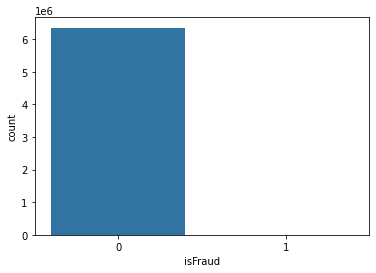

In [100]:
# Most of transactions is non-Fraud

sns.countplot(df1['isFraud']);

### 4.1.1 Numerical attributes

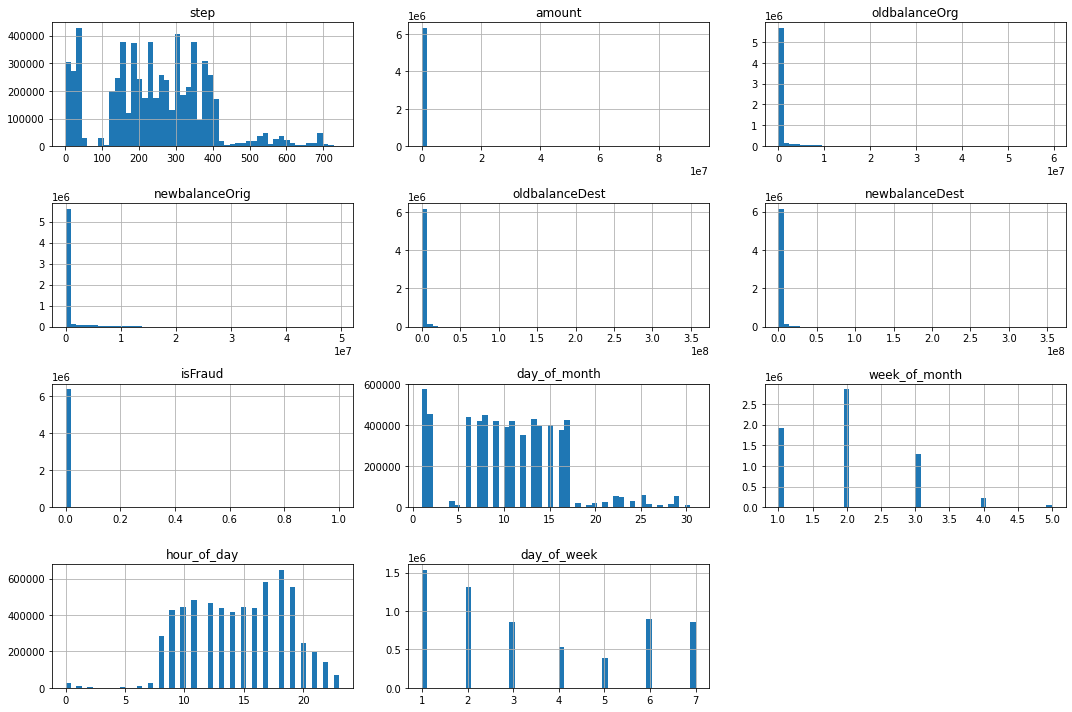

In [101]:
df1.select_dtypes(['float64', 'int64']).hist(figsize=(15,10), bins=50);
plt.tight_layout()

### 4.1.2 Categorical attributes

In [102]:
cat_attrib = df1.select_dtypes(exclude=['int64','float64'])

cat_attrib = cat_attrib.drop(columns=['nameDest'])

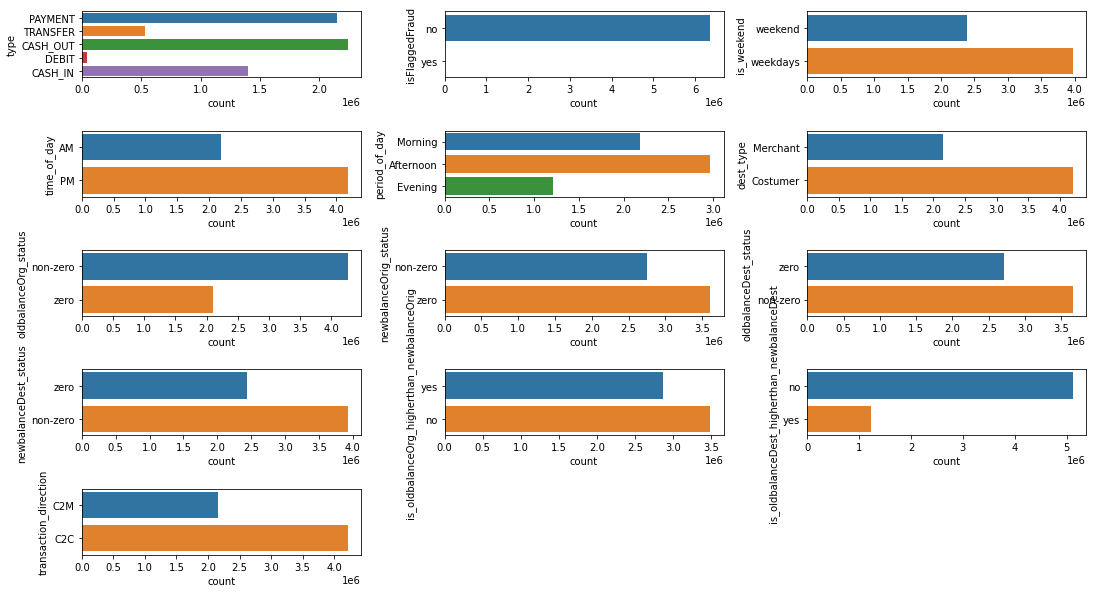

In [103]:
# sets plot size
plt.figure(figsize=(18, 10))

# sets the inital plot position
n = 1

# iterates over the columns to plot
for i in cat_attrib.columns:
    plt.subplot(5, 3, n)
    _ = sns.countplot(y=cat_attrib[i])
    n += 1

# adjust height and wdith reserved for space between subplots  
plt.subplots_adjust(hspace=0.8)
plt.subplots_adjust(wspace=0.3)

# # display the plot
plt.show()

## 4.2 Bivariate analysis

### 4.2.1 Validating hypothesis raised

Validating hipothesis raised:

- <b>Transaction type:</b><br>
  **1.** cash out and transfer are responsible for most of fraud transactions<br>
  <br>
- <b>Transaction time:</b><br>
  **2.** fraud happens mostly AM<br>
  **3.** fraud happens mostly in the morning<br>
  **4.** fraud happens mostly during weekdays<br>
  **5.** fraud transactions frequencies follow the trend of non-fraud transactions.<br>
  <br>
- <b>Transaction origin:</b><br>
  **6.** most fraud transactions happen when origin old balance is non-zero<br>
  **7.** most fraud transactions happen when origin new balance is zero<br>
  <br>
- <b>Transaction destination:</b><br>
  **8.** most fraud transactions happen when destination new balance is non-zero<br>
  **9.** most fraud happens for costumer as destination type<br>
  <br>
- <b>Transaction amount:</b><br>
  **10.** the average 'amount' of fraud transactions is higher than non-fraud transactions<br>
  <br>
- <b>Transaction direction:</b><br>
  **11.** most fraud transactions happen in C2C direction<br>
  <br>
- <b>Flagging:</b><br>
  **12.** most of fraud transactions are not flagged


- <b><font color="brown">Transaction type:</font></b><br>
  **1.** cash out and transfer are responsible for most of fraud transactions<br>
  <b>ANSWER:</b> <i>for fraud transactions there are no 'PAYMENT', 'DEBIT', 'CASH_IN' transactions, just 'TRANSFER', 'CASH_OUT', which represents almost 50% each.</i>

<AxesSubplot:xlabel='type', ylabel='count'>

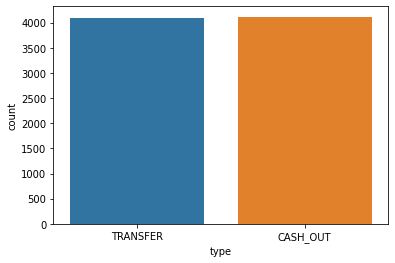

In [104]:
sns.countplot(df1.loc[df1['isFraud']==1,'type'])


- <b><font color="green">Transaction time:</font></b><br>
  **2.** fraud happens mostly AM<br>
  <b>ANSWER:</b> <i>TRUE. Fraud transactions mostly happen AM.</i>

<AxesSubplot:xlabel='time_of_day', ylabel='count'>

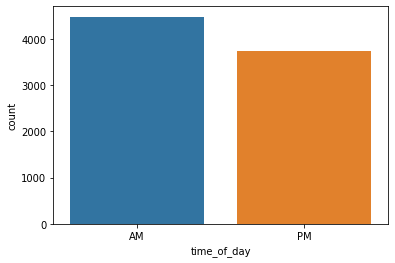

In [105]:
sns.countplot(df1.loc[df1['isFraud']==1,'time_of_day'])

<AxesSubplot:xlabel='time_of_day', ylabel='count'>

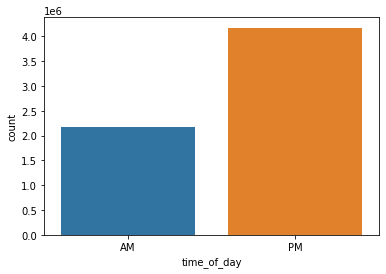

In [106]:
# Non-fraud transactions, however, happen in the opposite direction

sns.countplot(df1.loc[df1['isFraud']==0,'time_of_day'])


- <b><font color="green">Transaction time:</font></b><br>
  **3.** fraud happens mostly in the morning<br>
  <b>ANSWER:</b> <i>TRUE. Fraud transactions mostly happen in the morning.</i>

<AxesSubplot:xlabel='period_of_day', ylabel='count'>

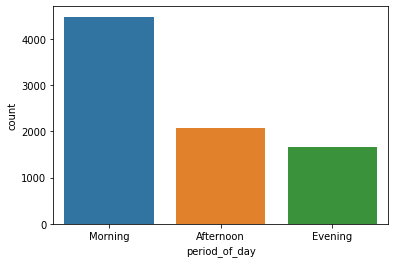

In [107]:
sns.countplot(df1.loc[df1['isFraud']==1,'period_of_day'])

<AxesSubplot:xlabel='period_of_day', ylabel='count'>

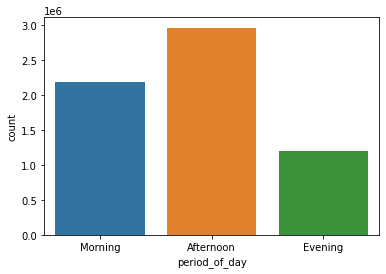

In [108]:
# Compared to non-Fraud transactions which happen mostly in the afternoon

sns.countplot(df1.loc[df1['isFraud']==0,'period_of_day'])


- <b><font color="green">Transaction time:</font></b><br>
  **4.** fraud happens mostly during weekdays<br>
  <b>ANSWER:</b> <i>True. Fraud happens mostly during weekdays</i>

<AxesSubplot:xlabel='is_weekend', ylabel='count'>

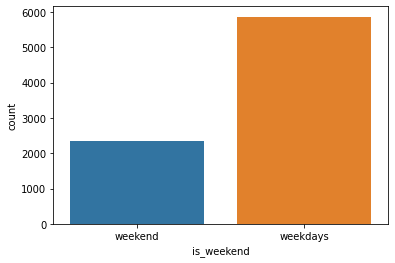

In [109]:
sns.countplot(df1.loc[df1['isFraud']==1,'is_weekend'])

<AxesSubplot:xlabel='is_weekend', ylabel='count'>

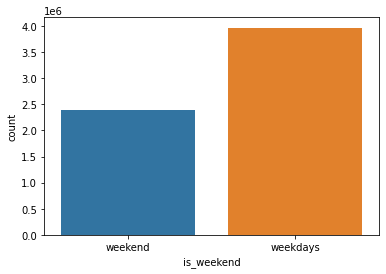

In [110]:
# Non-fraud transactions have the same behaviour

sns.countplot(df1.loc[df1['isFraud']==0,'is_weekend'])


- <b><font color="green">Transaction time:</font></b><br>
  **5.** fraud transactions frequencies follow the trend of non-Fraud transactions.<br>
  <b>ANSWER:</b> <i>False. Fraud happens with diferent frequencie distribution.</i>

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

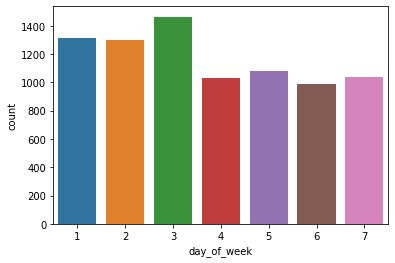

In [111]:
sns.countplot(df1.loc[df1['isFraud']==1,'day_of_week'])

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

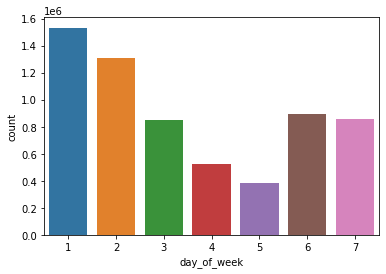

In [112]:
sns.countplot(df1.loc[df1['isFraud']==0,'day_of_week'])


- <b><font color="brown">Transaction origin:</font></b><br>
  **6.** most fraud transactions happen when origin old balance is non-zero<br>
  <b>ANSWER:</b> <i>True. Althought there are some frauds where the Origin old balance is zero, the majority of fraud events happened when it was non-zero.</i>

<AxesSubplot:xlabel='oldbalanceOrg_status', ylabel='count'>

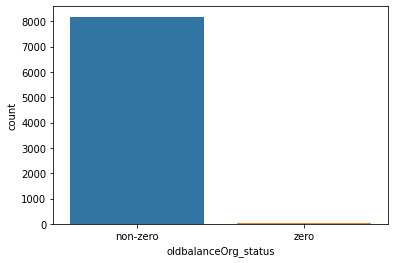

In [113]:
sns.countplot(df1.loc[df1['isFraud']==1,'oldbalanceOrg_status'])

<AxesSubplot:xlabel='oldbalanceOrg_status', ylabel='count'>

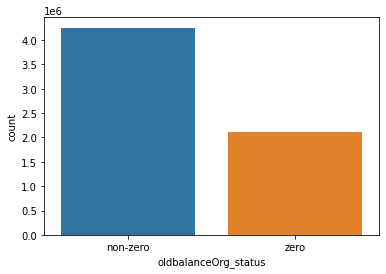

In [114]:
# For non-fraud transactions non-zero/zero ratio is different

sns.countplot(df1.loc[df1['isFraud']==0,'oldbalanceOrg_status'])


- <b><font color="brown">Transaction origin:</font></b><br>
  **7.** most fraud transactions happen when origin new balance is zero<br>
  <b>ANSWER:</b> <i>True. After most fraud transactions the remaining origin balance is zero.</i>

<AxesSubplot:xlabel='newbalanceOrig_status', ylabel='count'>

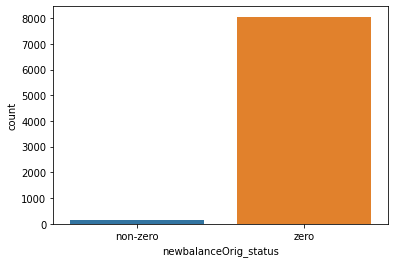

In [115]:
sns.countplot(df1.loc[df1['isFraud']==1,'newbalanceOrig_status'],
              order= sorted(df1.loc[df1['isFraud']==1,'newbalanceOrig_status'].unique().tolist()))

<AxesSubplot:xlabel='newbalanceOrig_status', ylabel='count'>

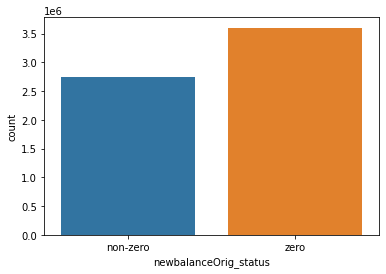

In [116]:
# For non-fraud transactions the non-zero/zero ratio is different

sns.countplot(df1.loc[df1['isFraud']==0,'newbalanceOrig_status'],
              order= sorted(df1.loc[df1['isFraud']==0,'newbalanceOrig_status'].unique().tolist()))


- <b><font color= "green">Transaction destination:</font></b><br>
  **8.** most fraud transactions happen when destination new balance is non-zero<br>
  <b>ANSWER:</b> <i>False. For both zero and non-zero remaining balance they are equally frequent.</i>

<AxesSubplot:xlabel='newbalanceDest_status', ylabel='count'>

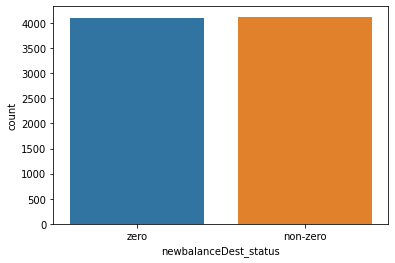

In [117]:
sns.countplot(df1.loc[df1['isFraud']==1,'newbalanceDest_status'])

<AxesSubplot:xlabel='newbalanceDest_status', ylabel='count'>

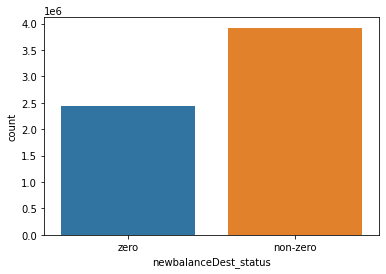

In [118]:
# For non-fraud though, non-zero remaining balance is the most frequent after transaction.

sns.countplot(df1.loc[df1['isFraud']==0,'newbalanceDest_status'])


- <b><font color= "green">Transaction destination:</font></b><br>
  **9.** most fraud happens for costumer as destination type<br>
  <b>ANSWER:</b> <i>True. Fraud ONLY happens for Costumers as destination.</i>

<AxesSubplot:xlabel='dest_type', ylabel='count'>

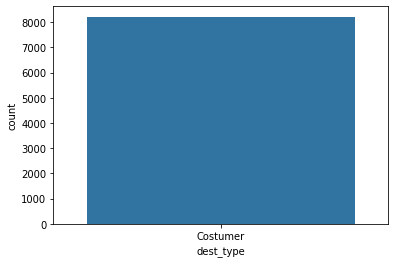

In [119]:
sns.countplot(df1.loc[df1['isFraud']==1,'dest_type'])


- <b><font color="brown">Transaction amount:</font></b><br>
  **10.** the average 'amount' of fraud transactions is higher than non-fraud transactions<br>
  <b>ANSWER:</b> <i>True.</i>

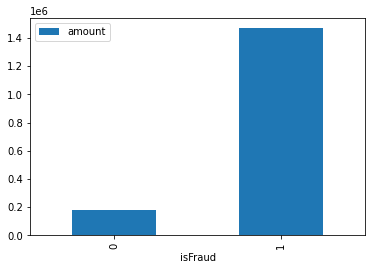

In [120]:
df1[['isFraud', 'amount']].groupby('isFraud').mean().plot.bar();


- <b><font color="green">Transaction direction:</font></b><br>
  **11.** most fraud transactions happen in C2C direction<br>
  <b>ANSWER:</b> <i>fraud transactions ONLY happen in C2C direction.</i>

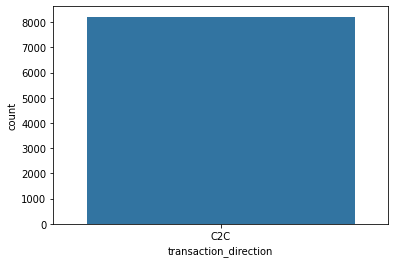

In [121]:
sns.countplot(df1.loc[df1['isFraud']==1, 'transaction_direction']);


- <b><font color="brown">Flagging:</font></b><br>
  **12.** most of fraud transactions is not flagged<br>
  <b>ANSWER:</b> <i>True.</i>

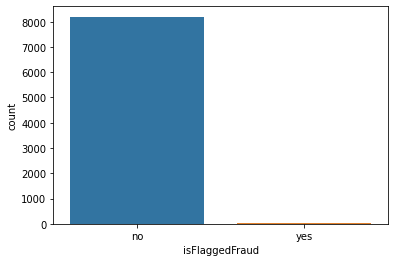

In [122]:
sns.countplot(df1.loc[df1['isFraud']==1, 'isFlaggedFraud']);

In [123]:
# Some important attributes after hypothesis validation procedure

# type

# time_of_day (AM and PM)

# period_of_day

# day_of_week

# oldbalanceOrg_status

# newbalanceOrig_status

# newbalanceDest_status (insight from H8)

# dest_type

# amount

# transaction_direction

# isFlaggedFraud

### 4.2.1 Statistical hypothesis testing

It will be applied to numeric continuous attributes:

- 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'

But first let's test to check if the data distribution of these features has a gaussian shape (parametric distribution) so we can further apply the correct statistical test.

In [124]:
# stat, p = shapiro(data) <- test sintax

In [125]:
for i in ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:

  stat, p = stats.shapiro(df1.loc[:, i])
  
  print('Feature: {}'.format(i))
  print('stat=%.3f, p=%.3f' % (stat, p))

  if p > 0.05:
    print('Probably Gaussian\n')

  else:
    print('Probably not Gaussian\n')

Feature: amount
stat=0.193, p=0.000
Probably not Gaussian

Feature: oldbalanceOrg
stat=0.323, p=0.000
Probably not Gaussian

Feature: newbalanceOrig
stat=0.331, p=0.000
Probably not Gaussian

Feature: oldbalanceDest
stat=0.299, p=0.000
Probably not Gaussian

Feature: newbalanceDest
stat=0.302, p=0.000
Probably not Gaussian



Since these features probably have a not Gaussian shape we will apply Mann-Whitney non-parametric test:

In [126]:
# stat, p = mannwhitneyu(data1, data2)  <- test sintax

In [127]:
for i in ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:

  stat, p = stats.mannwhitneyu(df1.loc[df1['isFraud']==0, i], 
                               df1.loc[df1['isFraud']==1, i])
  
  print('Feature: {}'.format(i))
  print('stat=%.3f, p=%.3f' % (stat, p))

  if p > 0.05:
    print('Probably the same distribution\n')

  else:
    print('Probably different distributions\n')

Feature: amount
stat=10963745080.000, p=0.000
Probably different distributions

Feature: oldbalanceOrg
stat=9850780655.000, p=0.000
Probably different distributions

Feature: newbalanceOrig
stat=36728357058.500, p=0.000
Probably different distributions

Feature: oldbalanceDest
stat=33005101397.000, p=0.000
Probably different distributions

Feature: newbalanceDest
stat=28206477161.000, p=0.000
Probably different distributions



Results above show us that attributes 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest' are also important in statistical point of view.

## 4.3 Multivariate analysis

### 4.3.1 Numerical attributes

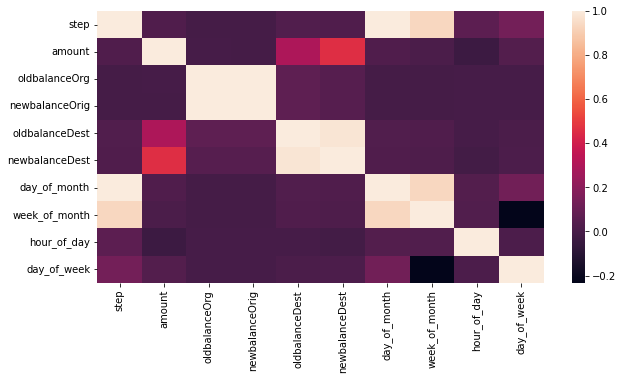

In [128]:
plt.figure(figsize=(10,5))

sns.heatmap(df1[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
                 'newbalanceDest', 'day_of_month', 'week_of_month','hour_of_day', 
                 'day_of_week']].corr());

### 4.3.2 Categorical attributes

<AxesSubplot:>

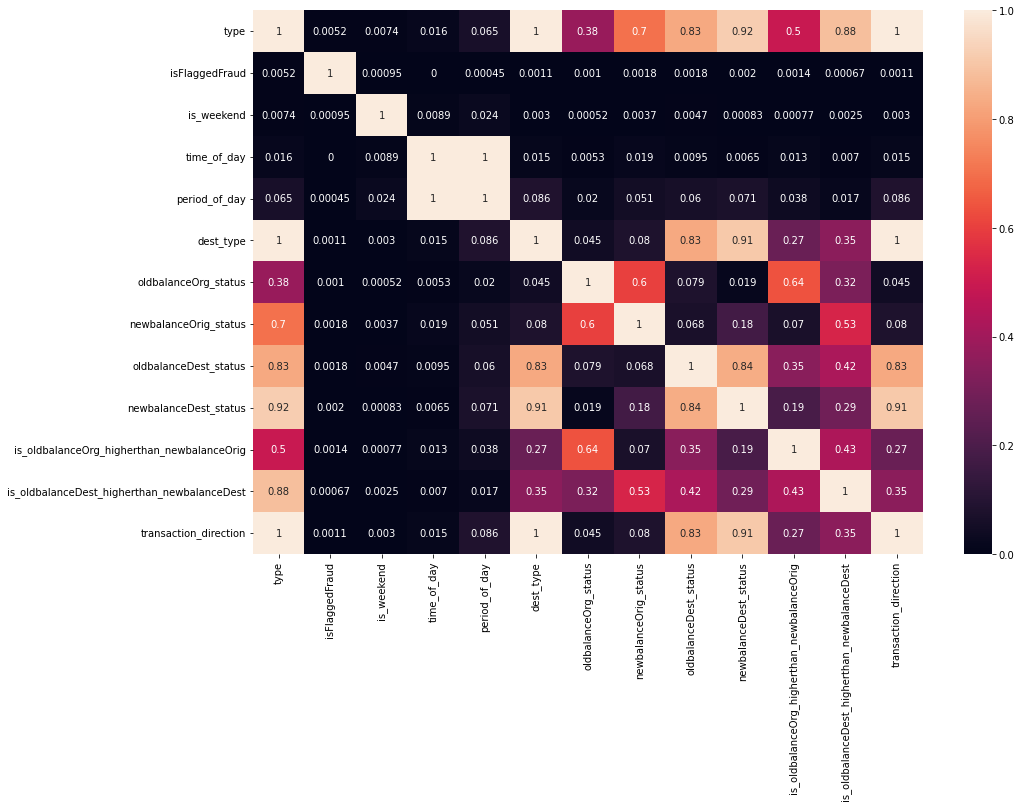

In [129]:
plt.figure(figsize=(15,10))

plot_corr(df1,['type', 'isFlaggedFraud', 'is_weekend',
               'time_of_day', 'period_of_day', 'dest_type',
               'oldbalanceOrg_status', 'newbalanceOrig_status',
               'oldbalanceDest_status', 'newbalanceDest_status',
               'is_oldbalanceOrg_higherthan_newbalanceOrig', 
               'is_oldbalanceDest_higherthan_newbalanceDest', 'transaction_direction'])

# 5- Data Preparation

In [130]:
df2 = df1.copy()

## 5.1 Train/Test split

In [131]:
# Train/Test split

# X_train, X_test, y_train, y_test = train_test_split(y, X, test_size=0.33, random_state=42) <- sintax

y_train, y_test, X_train, X_test = train_test_split(df2['isFraud'], 
                                                    df2.drop(columns=['isFraud']), 
                                                    test_size=0.33, 
                                                    random_state=42)

In [132]:
print('Data information:\n')

print('Training set:')
print('Observations number: {}'.format(len(y_train)))
print('Percentage: {}\n'.format(round(len(y_train)/len(df2['isFraud']),2)))

print('Testing set:')
print('Observations number: {}'.format(len(y_test)))
print('Percentage: {}\n'.format(round(len(y_test)/len(df2['isFraud']),2)))

Data information:

Training set:
Observations number: 4262955
Percentage: 0.67

Testing set:
Observations number: 2099665
Percentage: 0.33



## 5.2 Scaling - Numeric attributes

In [133]:
# Numeric non-cyclic attributes - Robust Scaler (each of them has extreme values)

# 'amount'

scaler = RobustScaler()

X_train['amount'] = scaler.fit_transform(X_train[['amount']].values)

X_test['amount'] = scaler.transform(X_test[['amount']].values) # scaling X_test using scaled already fitted


# 'oldbalanceOrg'

scaler = RobustScaler()

X_train['oldbalanceOrg'] = scaler.fit_transform(X_train[['oldbalanceOrg']].values)

X_test['oldbalanceOrg'] = scaler.transform(X_test[['oldbalanceOrg']].values) # scaling X_test using scaled already fitted


# 'newbalanceOrig'

scaler = RobustScaler()

X_train['newbalanceOrig'] = scaler.fit_transform(X_train[['newbalanceOrig']].values)

X_test['newbalanceOrig'] = scaler.transform(X_test[['newbalanceOrig']].values) # scaling X_test using scaled already fitted


# 'oldbalanceDest'

scaler = RobustScaler()

X_train['oldbalanceDest'] = scaler.fit_transform(X_train[['oldbalanceDest']].values)

X_test['oldbalanceDest'] = scaler.transform(X_test[['oldbalanceDest']].values) # scaling X_test using scaled already fitted


# 'newbalanceDest'

scaler = RobustScaler()

X_train['newbalanceDest'] = scaler.fit_transform(X_train[['newbalanceDest']].values)

X_test['newbalanceDest'] = scaler.transform(X_test[['newbalanceDest']].values) # scaling X_test using scaled already fitted


# 'day_of_month'

scaler = RobustScaler()

X_train['day_of_month'] = scaler.fit_transform(X_train[['day_of_month']].values)

X_test['day_of_month'] = scaler.transform(X_test[['day_of_month']].values) # scaling X_test using scaled already fitted


# 'week_of_month'

scaler = RobustScaler()

X_train['week_of_month'] = scaler.fit_transform(X_train[['week_of_month']].values)

X_test['week_of_month'] = scaler.transform(X_test[['week_of_month']].values) # scaling X_test using scaled already fitted


# 'step'

scaler = RobustScaler()

X_train['step'] = scaler.fit_transform(X_train[['step']].values)

X_test['step'] = scaler.transform(X_test[['step']].values) # scaling X_test using scaled already fitted


## 5.3 Encoding - Categorical attributes

In [134]:
# Dummies

# Features to encode via Dummies:

# 'isFlaggedFraud', 

# 'is_weekend', 

# 'time_of_day', 

# 'dest_type', 

# 'oldbalanceOrg_status', 

# 'newbalanceOrig_status', 

# 'oldbalanceDest_status', 

# 'newbalanceDest_status', 

# 'is_oldbalanceOrg_higherthan_newbalanceOrig', 

# 'is_oldbalanceDest_higherthan_newbalanceDest', 

# 'transaction_direction'

In [135]:
# Getting Dummie variables

X_train = pd.get_dummies(data=X_train, 
                         columns=['isFlaggedFraud', 'is_weekend', 'time_of_day', 'dest_type', 'oldbalanceOrg_status', 'newbalanceOrig_status', 'oldbalanceDest_status', 'newbalanceDest_status', 'is_oldbalanceOrg_higherthan_newbalanceOrig', 'is_oldbalanceDest_higherthan_newbalanceDest', 'transaction_direction'])

In [136]:
# Getting Dummie variables - X_test

X_test = pd.get_dummies(data=X_test, 
                         columns=['isFlaggedFraud', 'is_weekend', 'time_of_day', 'dest_type', 'oldbalanceOrg_status', 'newbalanceOrig_status', 'oldbalanceDest_status', 'newbalanceDest_status', 'is_oldbalanceOrg_higherthan_newbalanceOrig', 'is_oldbalanceDest_higherthan_newbalanceDest', 'transaction_direction'])

In [137]:
# Frequency encoding: 'nameDest'


# feature 'nameDest' has too many levels - let's encode using Frequency encoding

# enc_nom_1 = (train.groupby('nom_1').size()) / len(train) <- sintax (step 1)

# train['nom_1_encode'] = train['nom_1'].apply(lambda x : enc_nom_1[x]) <- sintax (step 2)



enc_nom_1 = (X_train.groupby('nameDest').size()) / len(X_train)

X_train['nameDest'] = X_train['nameDest'].apply(lambda x : enc_nom_1[x])

In [138]:
# encoding X_test:

enc_nom_1 = (X_test.groupby('nameDest').size()) / len(X_test)

X_test['nameDest'] = X_test['nameDest'].apply(lambda x : enc_nom_1[x])

In [139]:
# Label encoding - 'type'


le = LabelEncoder()

X_train['type'] = le.fit_transform(X_train['type'])


In [140]:
X_test['type'] = le.transform(X_test['type']) # encoding X_test

## 5.4 Cyclic transform

In [141]:
# Cyclic variables:

# hour_of_day

# day_of_week

# period_of_day

In [142]:
# First let's just encode 'period_of_day' from string to numbers 


# period_of_day (Label encoder)

period_of_day_encoding_map = {'Morning': 1, 'Afternoon':2, 'Evening':3}

X_train['period_of_day'] = X_train['period_of_day'].map(period_of_day_encoding_map)

X_test['period_of_day'] = X_test['period_of_day'].map(period_of_day_encoding_map)


In [143]:
# Transforming the attributes

# hour_of_day

X_train['hour_of_day_sin'] = X_train['hour_of_day'].apply(lambda x: np.sin(x*(2.*np.pi/24))) 
X_train['hour_of_day_cos'] = X_train['hour_of_day'].apply(lambda x: np.cos(x*(2.*np.pi/24)))

# day_of_week

X_train['day_of_week_sin'] = X_train['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
X_train['day_of_week_cos'] = X_train['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))


# period_of_day

X_train['period_of_day_sin'] = X_train['period_of_day'].apply(lambda x: np.sin(x*(2.*np.pi/3)))
X_train['period_of_day_cos'] = X_train['period_of_day'].apply(lambda x: np.cos(x*(2.*np.pi/3)))



In [144]:
# Dropping the precursor attributes 

X_train = X_train.drop(columns=['hour_of_day','day_of_week', 'period_of_day'])

In [145]:
# Transforming the attributes - X_test

# hour_of_day

X_test['hour_of_day_sin'] = X_test['hour_of_day'].apply(lambda x: np.sin(x*(2.*np.pi/24))) 
X_test['hour_of_day_cos'] = X_test['hour_of_day'].apply(lambda x: np.cos(x*(2.*np.pi/24)))

# day_of_week

X_test['day_of_week_sin'] = X_test['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
X_test['day_of_week_cos'] = X_test['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))


# period_of_day

X_test['period_of_day_sin'] = X_test['period_of_day'].apply(lambda x: np.sin(x*(2.*np.pi/3)))
X_test['period_of_day_cos'] = X_test['period_of_day'].apply(lambda x: np.cos(x*(2.*np.pi/3)))


# Dropping the precursor attributes - X_test

X_test = X_test.drop(columns=['hour_of_day','day_of_week', 'period_of_day'])

In [146]:
X_train.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,day_of_month,week_of_month,isFlaggedFraud_no,isFlaggedFraud_yes,is_weekend_weekdays,is_weekend_weekend,time_of_day_AM,time_of_day_PM,dest_type_Costumer,dest_type_Merchant,oldbalanceOrg_status_non-zero,oldbalanceOrg_status_zero,newbalanceOrig_status_non-zero,newbalanceOrig_status_zero,oldbalanceDest_status_non-zero,oldbalanceDest_status_zero,newbalanceDest_status_non-zero,newbalanceDest_status_zero,is_oldbalanceOrg_higherthan_newbalanceOrig_no,is_oldbalanceOrg_higherthan_newbalanceOrig_yes,is_oldbalanceDest_higherthan_newbalanceDest_no,is_oldbalanceDest_higherthan_newbalanceDest_yes,transaction_direction_C2C,transaction_direction_C2M,hour_of_day_sin,hour_of_day_cos,day_of_week_sin,day_of_week_cos,period_of_day_sin,period_of_day_cos
1186641,-0.601124,0,0.574169,-0.085686,1.331044,4.222423e-06,2.582174,1.809906,-0.571429,-1.0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,2.588190e-01,-0.965926,-7.818315e-01,0.623490,0.866025,-0.5
1199598,-0.595506,1,0.058952,0.161218,0.000000,1.172895e-06,-0.140862,-0.115441,-0.571429,-1.0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,1,0,1,0,1.224647e-16,-1.000000,-7.818315e-01,0.623490,0.866025,-0.5
1185636,-0.601124,1,0.720079,0.068401,0.000000,6.802793e-06,6.594655,5.921888,-0.571429,-1.0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,2.588190e-01,-0.965926,-7.818315e-01,0.623490,0.866025,-0.5
6211424,1.960674,4,3.187331,0.105437,0.000000,2.814949e-06,2.141447,2.369462,2.142857,2.0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,2.588190e-01,-0.965926,-4.338837e-01,-0.900969,0.866025,-0.5
4452703,0.471910,3,-0.079990,0.146302,0.000000,2.345791e-07,-0.140862,-0.193175,0.571429,0.0,1,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,0,1,1,0,0,1,5.000000e-01,-0.866025,-2.449294e-16,1.000000,0.866025,-0.5


In [147]:
X_test.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,day_of_month,week_of_month,isFlaggedFraud_no,isFlaggedFraud_yes,is_weekend_weekdays,is_weekend_weekend,time_of_day_AM,time_of_day_PM,dest_type_Costumer,dest_type_Merchant,oldbalanceOrg_status_non-zero,oldbalanceOrg_status_zero,newbalanceOrig_status_non-zero,newbalanceOrig_status_zero,oldbalanceDest_status_non-zero,oldbalanceDest_status_zero,newbalanceDest_status_non-zero,newbalanceDest_status_zero,is_oldbalanceOrg_higherthan_newbalanceOrig_no,is_oldbalanceOrg_higherthan_newbalanceOrig_yes,is_oldbalanceDest_higherthan_newbalanceDest_no,is_oldbalanceDest_higherthan_newbalanceDest_yes,transaction_direction_C2C,transaction_direction_C2M,hour_of_day_sin,hour_of_day_cos,day_of_week_sin,day_of_week_cos,period_of_day_sin,period_of_day_cos
3737323,0.219101,0,1.307560,0.062326,2.434223,1.428799e-06,0.339346,-0.083202,0.285714,0.0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,-0.258819,-9.659258e-01,-0.974928,-0.222521,-0.866025,-0.5
264914,-1.258427,3,-0.323712,0.150876,0.129814,4.762665e-07,-0.140862,-0.193175,-1.285714,-1.0,1,0,0,1,0,1,0,1,1,0,1,0,0,1,0,1,0,1,1,0,0,1,-0.500000,-8.660254e-01,0.781831,0.623490,-0.866025,-0.5
85647,-1.286517,0,0.396330,0.861020,1.794744,5.238931e-06,0.072805,-0.149043,-1.285714,-1.0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0.707107,-7.071068e-01,0.781831,0.623490,0.866025,-0.5
5899326,0.921348,4,7.562571,-0.132085,0.000000,5.715197e-06,3.253943,4.081656,1.000000,1.0,1,0,1,0,0,1,1,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,-1.000000,-1.836970e-16,0.433884,-0.900969,-0.866025,-0.5
2544263,-0.185393,0,0.016936,27.086388,20.796885,1.905066e-06,0.300500,0.110689,-0.142857,0.0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,-0.258819,-9.659258e-01,0.974928,-0.222521,-0.866025,-0.5


<AxesSubplot:xlabel='hour_of_day_sin', ylabel='hour_of_day_cos'>

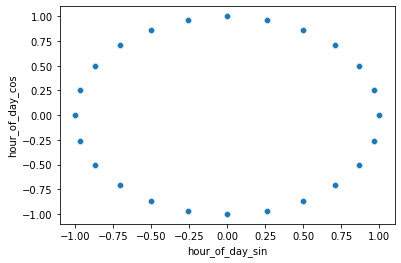

In [148]:
sns.scatterplot(x=X_train['hour_of_day_sin'], y=X_train['hour_of_day_cos'])

<AxesSubplot:xlabel='day_of_week_sin', ylabel='day_of_week_cos'>

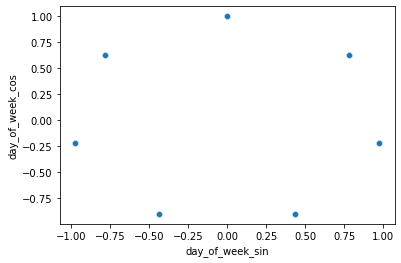

In [149]:
sns.scatterplot(x=X_train['day_of_week_sin'], y=X_train['day_of_week_cos'])

<AxesSubplot:xlabel='period_of_day_sin', ylabel='period_of_day_cos'>

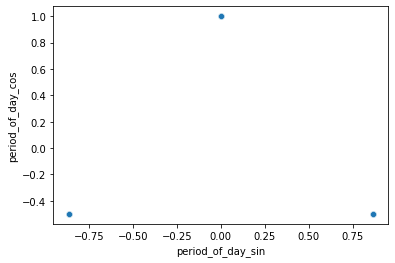

In [150]:
sns.scatterplot(x=X_train['period_of_day_sin'], y=X_train['period_of_day_cos'])

Checkpoint

In [ ]:
# saving datasets currently state

# X_train
pickle.dump(X_train, open('/mnt/d/Gustavo/fraud-detection/X_train.pkl', 'wb'))

# y_train
pickle.dump(y_train, open('/mnt/d/Gustavo/fraud-detection/y_train.pkl', 'wb'))

# X_test
pickle.dump(X_test, open('/mnt/d/Gustavo/fraud-detection/X_test.pkl', 'wb'))

# y_test
pickle.dump(y_test, open('/mnt/d/Gustavo/fraud-detection/y_test.pkl', 'wb'))


# 6- Feature Selection

In [ ]:
# Loading stored scaled train dataset

X_train = pickle.load(open('/mnt/d/Gustavo/fraud-detection/X_train.pkl', 'rb'))

y_train = pickle.load(open('/mnt/d/Gustavo/fraud-detection/y_train.pkl', 'rb'))


## 6.1 Boruta algorithm

In [ ]:
# Converting X and y train to np array

#X_train_1_np = X_train.values
#y_train_1_np = y_train.values


# Instantiating Boruta

boruta = BorutaPy(RandomForestClassifier(n_jobs=-1),
                  n_estimators='auto',
                  verbose=2,random_state=42).fit(X_train.values, y_train.values)

In [ ]:
boruta.support_.tolist()

## 6.2  Columns selected by Boruta

In [ ]:
cols_selected_boruta = X_train.loc[:, [True, True, True, True, False, True, True, True, True, False, False, False,
                                       False, False, False, False, False, False, False, False, False, False, True,
                                       False, True, True, False, False, False, False, False, False, True, True,
                                       False, False, False, False]].columns.tolist()

cols_not_selected_boruta = list(set(X_train.columns).difference(set(cols_selected_boruta )))

print('Features selected by Boruta:\n {}\n'.format(cols_selected_boruta))

print('Features not selected by Boruta:\n {}\n'.format(cols_not_selected_boruta))

<b>Important considerations about the importance of the features</b>

Features important from EDA, statistical test and Boruta standpoint:

- amount

Features important from statistical test and Boruta standpoint:

- oldbalanceOrg

- oldbalanceDest

- newbalanceDest


Features important from EDA and Boruta standpoint:

- type

- newbalanceDest_status


Features selected only by statistical test (not by Boruta):

- newbalanceOrig


Features important only by EDA (not by Boruta):

- time_of_day (AM and PM) 

- period_of_day

- day_of_week

- oldbalanceOrg_status

- newbalanceOrig_status

- dest_type

- transaction_direction

- isFlaggedFraud

# 7- Machine Learning

In [3]:
# Loading stored scaled train dataset

X_train = pickle.load(open('/mnt/d/Gustavo/fraud-detection/X_train.pkl', 'rb'))

y_train = pickle.load(open('/mnt/d/Gustavo/fraud-detection/y_train.pkl', 'rb'))

X_test = pickle.load(open('/mnt/d/Gustavo/fraud-detection/X_test.pkl', 'rb'))

y_test = pickle.load(open('/mnt/d/Gustavo/fraud-detection/y_test.pkl', 'rb'))


In [4]:
# Columns selected by Boruta

cols_selected_boruta = X_train.loc[:, [True, True, True, True, False, True, True, True, True, False, False, False,
                                       False, False, False, False, False, False, False, False, False, False, True,
                                       False, True, True, False, False, False, False, False, False, True, True,
                                       False, False, False, False]].columns.tolist()

In [5]:
# Defining datasets with Boruta-selected features


# X_train
X_train_boruta = X_train[cols_selected_boruta].copy()


# X_test
X_test_boruta = X_test[cols_selected_boruta].copy()



<b>Algorithms:</b>

Here we will evaluate some different machine learning algorithms to check which one best fits the data. First we will get model metrics from a baseline (random) model. Then, each different model resulting from the different evaluated algorithm will be compared to baseline model. It is expected for each model to, at least, perform better than baseline model.


<b>Model metrics:</b>

Since the dataset is strongly imbalanced, Accuracy should not be the metrics to look at. Instead we will pay attention to Balanced Accuracy, AUC, Precision, Recall and F1-score.

## 7.1 Baseline model

In [154]:
# Random model - setting

target_variables_list = y_train.unique().tolist() # target variables (class 0=non-Fraud, 1=Fraud)

k_num = y_test.shape[0] # k number of values to sample from (number of rows in y_test)

class_weights = y_test.value_counts(normalize=True).tolist() # proportion of samples of each class


# Random model

y_pred = random.choices(population=target_variables_list , weights=class_weights, k=k_num)


# Metrics: ========================================================================

print('Accuracy: {}\n'.format(round(metrics.accuracy_score(y_test, y_pred),3)))

print('Balanced Accuracy: {}\n'.format(round(metrics.balanced_accuracy_score(y_test, y_pred),3)))


# AUC ROC


# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1) <- sintax

fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                         np.array(y_pred), 
                                         pos_label=1)

metrics.auc(fpr, tpr)

print('AUC-ROC: {}\n'.format(round(metrics.auc(fpr, tpr),3)))




print('Classification report:\n\n {}'.format(metrics.classification_report(y_test, y_pred)))


# Gathering metrics for this estimator =============================================

baseline_accuracy = metrics.accuracy_score(y_test, y_pred)

baseline_bal_accuracy = metrics.balanced_accuracy_score(y_test, y_pred)

baseline_auc = metrics.auc(fpr, tpr)

baseline_precision = metrics.precision_score(y_test, y_pred)

baseline_f1 = metrics.f1_score(y_test, y_pred)

baseline_recall = metrics.recall_score(y_test, y_pred)



df_baseline = pd.DataFrame(data=['Baseline Model', baseline_accuracy, baseline_bal_accuracy, baseline_auc, baseline_precision, baseline_f1, baseline_recall]).transpose()

df_baseline.columns = ['Model name', 'Accuracy', 'Balanced Accuracy', 'AUC', 'Precision', 'F1-score', 'Recall']

df_baseline

Accuracy: 0.997

Balanced Accuracy: 0.5

AUC-ROC: 0.5

Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096999
           1       0.00      0.00      0.00      2666

    accuracy                           1.00   2099665
   macro avg       0.50      0.50      0.50   2099665
weighted avg       1.00      1.00      1.00   2099665



,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,Baseline Model,0.997404,0.499523,0.499523,0.000359,0.000367,0.000375


## 7.2 Logistic Regression

In [155]:


model_name = 'Logistic Regression'

model = LogisticRegression(random_state=42, n_jobs=-1, max_iter=10000)


df_log_reg = get_model_metrics(model_name, model, X_train_boruta, y_train, X_test_boruta, y_test)


df_log_reg

Accuracy: 0.999

Balanced Accuracy: 0.573

AUC-ROC: 0.868

Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096999
           1       0.89      0.15      0.25      2666

    accuracy                           1.00   2099665
   macro avg       0.95      0.57      0.62   2099665
weighted avg       1.00      1.00      1.00   2099665




,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,Logistic Regression,0.998893,0.572757,0.867702,0.894009,0.250323,0.145536


In [156]:
# sample weights svc (class_weight)


{y_test.value_counts(normalize=True).index[0]:y_test.value_counts(normalize=True).tolist()[0], y_test.value_counts(normalize=True).index[1]:y_test.value_counts(normalize=True).tolist()[1] }

{0: 0.99873027363889, 1: 0.0012697263611099866}

In [157]:


model_name = 'Logistic Regression balanced'

model = LogisticRegression(random_state=42, 
                           n_jobs=-1, 
                           max_iter=10000,
                          class_weight={y_test.value_counts(normalize=True).index[0]:y_test.value_counts(normalize=True).tolist()[0], y_test.value_counts(normalize=True).index[1]:
                                        y_test.value_counts(normalize=True).tolist()[1] })


get_model_metrics(model_name, model, X_train_boruta, y_train, X_test_boruta, y_test)



Accuracy: 0.999

Balanced Accuracy: 0.513

AUC-ROC: 0.839

Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096999
           1       0.99      0.03      0.05      2666

    accuracy                           1.00   2099665
   macro avg       0.99      0.51      0.52   2099665
weighted avg       1.00      1.00      1.00   2099665




,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,Logistic Regression balanced,0.998762,0.512753,0.838594,0.985507,0.049726,0.025506


## 7.3 Random Forest

In [158]:


model_name = 'Random Forest'

model = RandomForestClassifier(n_jobs=-1, random_state=42)


df_rf = get_model_metrics(model_name, model, X_train_boruta, y_train, X_test_boruta, y_test)


df_rf

Accuracy: 1.0

Balanced Accuracy: 0.894

AUC-ROC: 0.967

Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096999
           1       0.99      0.79      0.88      2666

    accuracy                           1.00   2099665
   macro avg       1.00      0.89      0.94   2099665
weighted avg       1.00      1.00      1.00   2099665




,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,Random Forest,0.999724,0.893658,0.966993,0.993845,0.87861,0.787322


## 7.4 XGBoost

In [159]:


model_name = 'XG Boost'

model = xgb.XGBClassifier(objective='binary:logistic',
                            n_estimators=100,
                            max_depth=10,
                            tree_method='exact',
                            n_jobs=-1,
                            random_state=42)


df_xgb = get_model_metrics(model_name, model, X_train_boruta, y_train, X_test_boruta, y_test)


df_xgb

Accuracy: 1.0

Balanced Accuracy: 0.913

AUC-ROC: 0.998

Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096999
           1       0.99      0.83      0.90      2666

    accuracy                           1.00   2099665
   macro avg       0.99      0.91      0.95   2099665
weighted avg       1.00      1.00      1.00   2099665




,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,XG Boost,0.999763,0.912596,0.998484,0.986105,0.898509,0.825206


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

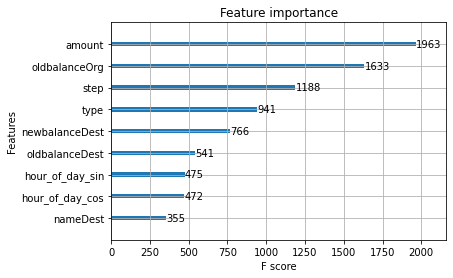

In [160]:
xgb.plot_importance(model)

## 7.5 KNN

In [161]:


model_name = 'KNN'

model = KNeighborsClassifier(n_jobs=-1)


df_knn = get_model_metrics(model_name, model, X_train_boruta, y_train, X_test_boruta, y_test)


df_knn

Accuracy: 1.0

Balanced Accuracy: 0.873

AUC-ROC: 0.915

Classification report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2096999
           1       0.97      0.75      0.84      2666

    accuracy                           1.00   2099665
   macro avg       0.98      0.87      0.92   2099665
weighted avg       1.00      1.00      1.00   2099665




,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,KNN,0.999649,0.873391,0.915126,0.9698,0.843823,0.746812


##  <font><i>Summary of metrics</i></font>

In [162]:
pd.concat([df_baseline, df_log_reg, df_rf, df_xgb, df_knn])

,Model name,Accuracy,Balanced Accuracy,AUC,Precision,F1-score,Recall
0,Baseline Model,0.997404,0.499523,0.499523,0.000359,0.000367,0.000375
0,Logistic Regression,0.998893,0.572757,0.867702,0.894009,0.250323,0.145536
0,Random Forest,0.999724,0.893658,0.966993,0.993845,0.87861,0.787322
0,XG Boost,0.999763,0.912596,0.998484,0.986105,0.898509,0.825206
0,KNN,0.999649,0.873391,0.915126,0.9698,0.843823,0.746812


##  <font><i>Cross-validation</i></font>

In [ ]:
model = xgb.XGBClassifier(objective='binary:logistic',
                          n_estimators=100,
                          max_depth=10,
                          tree_method='exact',
                          n_jobs=-1,
                          random_state=42)

kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

results_recall = cross_val_score(model, X_train_boruta, y_train, cv=kfold, n_jobs=-1, verbose=1, scoring='recall')

In [ ]:
print("Recall: %.2f%% (%.2f%%)" % (results_recall.mean()*100, results_recall.std()*100))

In [25]:
# Cross-validation - XG Boost

# Metrics to search
list_metrics_to_search = ['accuracy','balanced_accuracy', 'roc_auc', 'precision', 'f1', 'recall']


# Creating a empty df
df_metrics_cv = pd.DataFrame(columns=list_metrics_to_search) # columns
df_metrics_cv = df_metrics_cv.append({'accuracy': np.nan}, ignore_index=True) # filling the first row with NA
df_metrics_cv.index = ['XG Boost'] # setting the string 'XG Boost' as df index


# Instantiating the classifier
model = xgb.XGBClassifier(objective='binary:logistic',
                          n_estimators=100,
                          max_depth=10,
                          tree_method='exact',
                          n_jobs=-1,
                          random_state=42)

# Setting the folds (shuffle=True due to imbalance in dataset)
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


# loop for metrics evaluation within cross-validation
for i in list_metrics_to_search:
    
    print('Now evaluating: {}'.format(i))
    
    
    results_cv = cross_val_score(model, X_train_boruta, y_train, cv=kfold, n_jobs=-1, verbose=1, scoring=i)
    
    print('Evaluation of {} status: Done'.format(i))
    
    
    print('Inserting {} results information to table'.format(i))
    
    df_metrics_cv[i] = str(round(results_cv.mean(), 2))+' +/-'+str(round(results_cv.std(), 2))
    
    print('Insertion done.\n')
    
    print('{}\n'.format(df_metrics_cv))
    
    
print('Metrics calculation fisinhed.\n')


print('Stratified k-fold Cross-validation results:')
df_metrics_cv


Now evaluating: accuracy


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 38.1min finished


Evaluation of accuracy status: Done
Inserting accuracy results information to table
Insertion done.

            accuracy balanced_accuracy roc_auc precision   f1 recall
XG Boost  1.0 +/-0.0               NaN     NaN       NaN  NaN    NaN

Now evaluating: balanced_accuracy


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 37.9min finished


Evaluation of balanced_accuracy status: Done
Inserting balanced_accuracy results information to table
Insertion done.

            accuracy balanced_accuracy roc_auc precision   f1 recall
XG Boost  1.0 +/-0.0      0.91 +/-0.01     NaN       NaN  NaN    NaN

Now evaluating: roc_auc


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 38.0min finished


Evaluation of roc_auc status: Done
Inserting roc_auc results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc precision   f1 recall
XG Boost  1.0 +/-0.0      0.91 +/-0.01  1.0 +/-0.0       NaN  NaN    NaN

Now evaluating: precision


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 38.1min finished


Evaluation of precision status: Done
Inserting precision results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc     precision   f1 recall
XG Boost  1.0 +/-0.0      0.91 +/-0.01  1.0 +/-0.0  0.98 +/-0.01  NaN    NaN

Now evaluating: f1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 38.1min finished


Evaluation of f1 status: Done
Inserting f1 results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc     precision           f1  \
XG Boost  1.0 +/-0.0      0.91 +/-0.01  1.0 +/-0.0  0.98 +/-0.01  0.9 +/-0.01   

         recall  
XG Boost    NaN  

Now evaluating: recall


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 38.0min finished


Evaluation of recall status: Done
Inserting recall results information to table
Insertion done.

            accuracy balanced_accuracy     roc_auc     precision           f1  \
XG Boost  1.0 +/-0.0      0.91 +/-0.01  1.0 +/-0.0  0.98 +/-0.01  0.9 +/-0.01   

                recall  
XG Boost  0.83 +/-0.02  

Metrics calculation fisinhed.

Stratified k-fold Cross-validation results:


,accuracy,balanced_accuracy,roc_auc,precision,f1,recall
XG Boost,1.0 +/-0.0,0.91 +/-0.01,1.0 +/-0.0,0.98 +/-0.01,0.9 +/-0.01,0.83 +/-0.02


##  <font><i>Hiperparameter fine tuning</i></font>

In [ ]:
# Hyperparameter fine tuning for XG Boost


# model instance
model = xgb.XGBClassifier(objective='binary:logistic',
                            n_estimators=100,
                            max_depth=10,
                            tree_method='exact',
                            n_jobs=-1,
                            random_state=42)

# parameters to search
parameters = {'n_estimators':[1500, 1700, 2500, 3000, 3500],
              'eta':[0.01, 0.03],
              'max_depth':[3, 5, 9],
              'subsample':[0.1, 0.5, 0.7],
              'colsample_bytree':[0.3, 0.7, 0.9],
              'min_child_weight':[3, 8, 15]} # choosing the interval values to evaluate


# cross-validation strategy
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


# setting RandomSearchCV instance
clf = RandomizedSearchCV(model, parameters, random_state=42, scoring='recall', n_jobs=-1, cv=kfold, verbose=3)

print("Randomized search..")
search_time_start = time.time()

print("Randomized search time:", time.time() - search_time_start)


# fitting to data
search = clf.fit(X_train_boruta, y_train)



Randomized search..
Randomized search time: 0.00044536590576171875
Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
search.best_params_

In [ ]:
# Precision-Recall curve

print('Precision-Recall curve:')
metrics.plot_precision_recall_curve(log_reg, X_test_boruta, y_test);


# Confusion matrix curve

print('Confusion Matrix:')
metrics.plot_confusion_matrix(log_reg, X_test_boruta, y_test);

# <font face="Arial" color="red">Racunhos</font>

In [ ]:
# LEMBRETES GERAIS:

# eliminar dados duplicados - OK

# fazer teste de hipótese (teste t) na análise bivariada - OK

# No tuning de hiperparâmetros melhorar a métrica recall


# Checklist geral: ==================================================================


# Limpeza dos dados - OK

# Substituicao de dados faltantes - OK

# Criacao de features para modelar o fenomeno - OK

# EDA - OK

# Desbalanceamento dos dados

# Escala dos dados - OK

# Selecao de features - OK

# Vies do modelo



# Limitações do projeto: =============================================================


# Dataset de apenas 1 mês (comportamento de fraude de diferentes meses não capturado)



In [ ]:
# Sugestões para Ciclo 2:


# Verificar se dá pra incluir informações do desbalanceamento de classes no Boruta

# Incluir as features importantes no EDA mas que foram descartados pelo Boruta

In [ ]:
# References:

# Frequency encoding: https://www.kaggle.com/bhavikapanara/frequency-encoding

# Cross-validation (XG Boost): https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/

# Random search (XG Boost): https://gist.github.com/wrwr/3f6b66bf4ee01bf48be965f60d14454d
